In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing import timeseries_dataset_from_array #these two ended up not being used
from keras.preprocessing.sequence import TimeseriesGenerator
import math
from tensorflow.keras.initializers import HeUniform

C:\Users\c334-\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



# Conly Sharp
# Swiss Market Index Short Term Price Prediction

Here is the notebook file for the project. We'll go over code, analyze outputs, and show all of our hyperparameter tuning here. There will also be a PDF file for the report as well, which won't be too long, and puts the information we find in a nice clean format. First let's talk a little bit about the goal and motives, our plan for achieving the goal, and theorize on some potential outcomes.

# Goal
The goal of this project is to construct a feed-forward neural network which can predict short term price predictions in certain stocks listed on the SIX Swiss Exchange. These stocks are selected from the Swiss Market Index (SMI), which are the twenty largest (market capitalization or overall value) and most liquid (i.e., able to be bought and sold with ease) listed on the SIX Swiss Exchange. For simplicity, think about these twenty constituents of the SMI as the best businnesses Switzerland has to offer. Hopefully, we can look at the historical price history of each constituent's stock and use this data to make a prediction for the next day, hour, or even minute (if this data can be readily acquired). This application would be useful for a range of financial practitioners such as investment and portfolio managers, traditional or quantitative traders, or even a personal investor. Predicting the price for the next day can help with risk managers, or even comprise a basis for an algorithmic trading strategy. Keep in mind all of these shares are listed in Swiss Francs (CHF), not dollars. One Swiss Franc is equivalent to around exactly a dollar as of October 2022, but before current market events it was more like 1 CHF = 1.11 USD.

# Plan
As previously stated, we aim to construct a feed-forward neural network which is able to predict future prices. Since we will output one numerical value, this is regression problem and there will be no classification, which can seemingly simplify many areas. We will start with a base benchmarking case- one hidden layer, sigmoid activation functions, few neurons, Stochastic Gradient Descent optimization. Once we get a proper benchmark and the results make sense, we will begin our hyperparameter tuning. The hyperparameter tuning will be guided by both educated predictions and some "hopeful" experimentation. Hopefully we can construct a network that has little deviation in prices. Let's aim for an error between the actual price and the predicted price of less than 5 CHF.

# Predictions
I predict a succesful benchmark test, and then some pretty straightforward hyperparameter tuning will improve the model handily. At the end of the tuning, it might be quite "accurate" but not enough to advise someone to deploy in an actual trading strategy using real time data.  The randomness of security prices stems from investor sentiments, which is an extremely difficult object to model. Successful forecasting used by quantitative funds use expensive information and complex algorithms that scrape web data for investor behavior as well as using much more advanced architectures. Since this is a feed-forward neural net, I believe we are hindered at what we could truly accomplish, a RNN or LSTM should produce better results. However, I thought this was a great exercise for a feed-forward and hopefully with further projects we can keep moving in the same direction and work towards models which might be more readily applicable to real-world scenarios.

# Data

Data acquisition is quite simple. Using the yfinance package, we can import data directly from Yahoo Finance at different timeframes into a CSV file which is easy to clean up and preprocess using Numpy and Pandas. I decided against Quandl because the Swiss Exchange data was quite expensive to acquire there, and since this is just an academic project, we don't need to take it so seriously as to purchase fancy minute-by-minute data like if we were trying to build a legitimate algorithmic trading strategy. I decided to take our data in the timeframe of March 2, 1999 to October 15, 2022, which starts us in the Dotcom crash, through the Global Recession, COVID, and the war in Ukraine which all severely affected the markets. As we split our data through time, we'll be training over the Dotcom and Global recessions, and test our data over Covid and the Russo-Ukrainian war. Taking this timeframe at one day a piece gives us over 5,000 trading days worth of information for each security. 

We'll be preprocessing our data to only be looking at the closing price for Nestle's stock. The closing price is the value in CHF of the last share sold for Nestle on that day. 

We will do our work with the price history from Nestle, preprocess our data, and run a backtest then tune hyperaparameters. Once we have the best model we can have, we'll do this for the actual Swiss Market Index. I'll also run the model on the other 19 constituents of the SMI so we can see the performance across other businesses, but I won't include this in the code because it will be tedious and the results will be available in the report.

Let's start by importing the data from Yahoo Finance and cleaning it up a bit.

In [2]:
data = yf.download("NESN.SW", start="1999-03-02", end="2022-10-15") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

[*********************100%***********************]  1 of 1 completed


In [3]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-04-02 00:00:00+02:00,26.650000,26.650000,26.650000,26.650000,14.920722,0.0
1999-04-05 00:00:00+02:00,26.650000,26.650000,26.650000,26.650000,14.920722,0.0
1999-05-13 00:00:00+02:00,29.129999,29.129999,29.129999,29.129999,16.309217,0.0
1999-05-24 00:00:00+02:00,28.420000,28.420000,28.420000,28.420000,15.911705,0.0
1999-11-12 00:00:00+01:00,28.860001,28.860001,28.860001,28.860001,16.158051,0.0
...,...,...,...,...,...,...
2022-10-10 00:00:00+02:00,105.779999,106.339996,104.760002,105.980003,105.980003,3094442.0
2022-10-11 00:00:00+02:00,105.639999,105.900002,103.940002,105.739998,105.739998,4656456.0
2022-10-12 00:00:00+02:00,105.699997,106.680000,105.580002,106.139999,106.139999,3841711.0


Now we can see how our data shape looks. It is a relatively straightforward dataframe, with prices of Nestle's stock indexed by time. This shouldn't be too difficult to preprocess. Let us remove any null values if there are any and filter out for the just the closing column because this is all we care about.

In [4]:
print(data.isna().sum())

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64


In [5]:
data= data.dropna() #remove null and check again
print(data.isna().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


Above is how our code looks in the dataframe. Since we only want to look at closing prices, we'll remove the rest of the information. Now we move on to splitting our data into testing and training sets. We'll use an 80/20 split, that is, the first 80% of the trading days will be our training data and the remaining 20% will be our test data. Additionally, we scale our values using the imported MinMax Scaler from Sklearn from range (0,1), which especially helps for sigmoid and tanh activation, but I suppose wouldn't hurt for ReLu either. Either way, it certainly protects from bias as our prices for the shares can reach high (post-COVID boom) and low (global recession). Additionally, it ensures we have proper scaled data with regard to any prices we'll see along the Swiss Exchange. We have to remember to unscale the values afterwards though so we can regenerate our predicted values in proper Swiss Franc pricing.

In [6]:
data = data[['Close']]
data

,Close
Date,
1999-04-02 00:00:00+02:00,26.650000
1999-04-05 00:00:00+02:00,26.650000
1999-05-13 00:00:00+02:00,29.129999
1999-05-24 00:00:00+02:00,28.420000
1999-11-12 00:00:00+01:00,28.860001
...,...
2022-10-10 00:00:00+02:00,105.980003
2022-10-11 00:00:00+02:00,105.739998
2022-10-12 00:00:00+02:00,106.139999


In [ ]:
data = data[['Close']] #filter out other column data
closeVals = data.values #turn our data to numpy array for manipulation

Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(closeVals) #scale data to help with gradient descent

scaledVals

array([[0.02788279],
       [0.02788279],
       [0.05132324],
       ...,
       [0.77920604],
       [0.768242  ],
       [0.77466922]])

In [ ]:
train = math.floor(len(closeVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

In [8]:
len(closeVals)

5434

In [9]:
train

4347

As we expected, we have 5,434 row of trading days and then 80% of that, 4347 days, makes up our training period. Great. The last thing we need to do before we can benchmark is to construct datasets which use the last months worth of closing prices to predict the next day's closing price. In this study we would like to use one month's worth of trading data (which would truly be 25 since you do not trade on weekends) so we use 30 days. We'll need to create training and testing lists and append our 30 days data inside them, then convert to arrays. We want our network to carry on our time series data to the next timestep with a predicted computation, which in our case is a day.

We convert these to numpy arrays and then reshape to ensure it can be fed to our model (we should expect input_shape[1]  = 30 for the month's data).

In [10]:
seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTest = scaledVals[train - seqdays: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices



trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  closeVals[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing



In [4]:
trainX.shape

(4317, 30)

In [5]:
trainY.shape

(4317,)

As we expected, trainX.shape[1] = 30 with 4,317 training days. Overall, data preprocessing wasn't too difficult because yfinance is an excellent module which provided us with very clean data to start.

Sources for data prep: 
https://www.relataly.com/regression-error-metrics-python/923/


https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/


# Benchmark

We have all our preprocessing done, let's run our benchmark and see how we do. Our benchmark model is about the simplest we can make it, with one hidden layer, sigmoid activation, and less neurons than we should probably have. We use a learning rate of 0.05 with stochastic gradient descent without momentum, 30 epochs. Loss function is mean squared error.

Epoch 1/30
135/135 [==============================] - 0s 792us/step - loss: 0.0217
Epoch 2/30
135/135 [==============================] - 0s 799us/step - loss: 0.0178
Epoch 3/30
135/135 [==============================] - 0s 784us/step - loss: 0.0146
Epoch 4/30
135/135 [==============================] - 0s 792us/step - loss: 0.0116
Epoch 5/30
135/135 [==============================] - 0s 754us/step - loss: 0.0087
Epoch 6/30
135/135 [==============================] - 0s 777us/step - loss: 0.0062
Epoch 7/30
135/135 [==============================] - 0s 837us/step - loss: 0.0042
Epoch 8/30
135/135 [==============================] - 0s 769us/step - loss: 0.0027
Epoch 9/30
135/135 [==============================] - 0s 725us/step - loss: 0.0017
Epoch 10/30
135/135 [==============================] - 0s 769us/step - loss: 0.0011
Epoch 11/30
135/135 [==============================] - 0s 777us/step - loss: 6.8988e-04
Epoch 12/30
135/135 [==============================] - 0s 739us/step - loss: 4.91

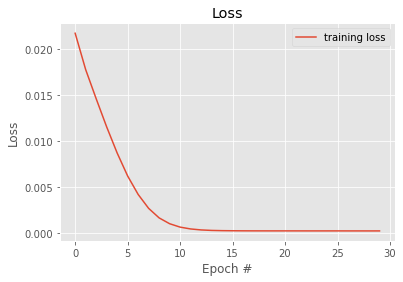

In [12]:
model = Sequential()
model.add(Dense(15, input_shape = (trainX.shape[1],) ,activation = 'sigmoid'))
model.add(Dense(8, activation = 'sigmoid'))
model.add(Dense(1,activation = 'linear'))


opt = SGD(learning_rate = 0.05)
model.compile(loss = 'mean_squared_error', optimizer = opt)


# train the model
maxEpoch = 30
H = model.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)


print('Test accuracy')



# plot the loss through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')


plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

The loss decreased well, but to truly see how the performance is, let's predict on our test data and plot to see how well we have computed future values. Remember we have to unscale our values back to Swiss Francs.

In [13]:
predictedClose = model.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

34/34 [==============================] - 0s 727us/step


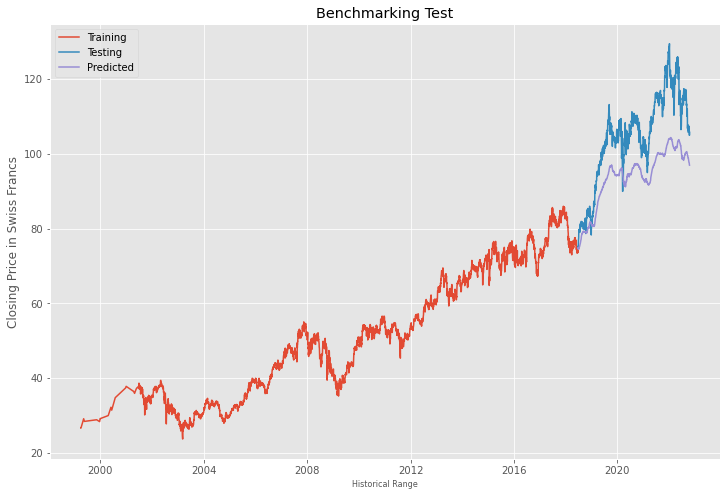

In [25]:
#Plot train, test, and predictions
time_train = data[:train] # 1d dataframe time zero to end of training 
time_prediction = data[train:] #1d dataframe time end of training to end of test
time_prediction['Predicted Close Price'] = predictedClose #creates prediction column in dataframe and adds predicted prices
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Price in Swiss Francs', fontsize=12)
plt.plot(time_train['Close'])
plt.plot(time_prediction[['Close', 'Predicted Close Price']])
plt.legend(['Training', 'Testing', 'Predicted'], loc='upper left')
plt.show()

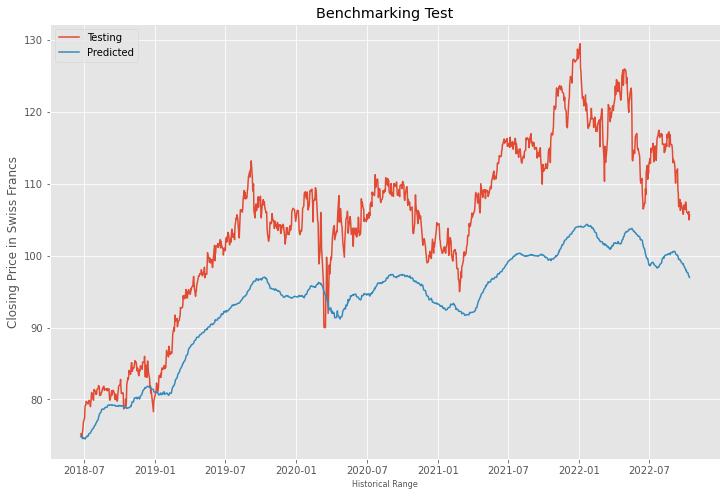

In [23]:
time_train = data[:train]
time_prediction = data[train:]
time_prediction['Predicted Close Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Price in Swiss Francs', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Close', 'Predicted Close Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

While it certainly is not fit at all, we can see it definitely can detect trends as the price oscillates with higher volatility. To further illustrate our prediction accuracy, let's look at our pricing data and compute the absolute mean of the difference for the whole test set. This will provide us a numerical standard to check how well our model is performing when we tune hyperparameters. We'll use a combination of this metric as well as simply looking at our fitted plot to see what is working.

In [16]:
time_prediction

,Close,Predicted Close Price
Date,,
2018-06-22 00:00:00+02:00,75.199997,74.889488
2018-06-25 00:00:00+02:00,74.820000,74.668770
2018-06-26 00:00:00+02:00,75.339996,74.645386
2018-06-27 00:00:00+02:00,75.660004,74.556534
2018-06-28 00:00:00+02:00,76.300003,74.675812
...,...,...
2022-10-10 00:00:00+02:00,105.980003,97.621773
2022-10-11 00:00:00+02:00,105.739998,97.359543
2022-10-12 00:00:00+02:00,106.139999,97.263268


In [17]:
time_prediction['diff'] = pd.Series.abs(time_prediction['Close'] - time_prediction['Predicted Close Price'])
time_prediction
time_prediction['diff'].mean()

10.892658826727985

The mean absolute error is almost 11 Swiss Francs. It would be lead one to financial ruin if we tried to invest with this model! Now, let's try to tune this up and make the plots fit better. We have many tools at our disposal for increasing performance such as different activation functions, learning rates, momentums, regularization methods, loss functions, initialization methods, and network architectures. 

# Hyperparameter Tuning

First, we'll decrease our learning rate to 0.01, add some momentum, and change our sigmoid activation function to ReLu. We'll set our momentum to 0.9 since this seems to be the norm. I believe switching our activation function to ReLu will also contribute, as ReLu takes care of vanishing gradient and the literature seems to point to ReLu leading to faster convergence (source A),

Source A: http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf

In [2]:
data = yf.download("NESN.SW", start="1999-03-02", end="2022-10-15")
data.to_csv('Nestle CSV')

data= data.dropna()

data = data[['Close']] #filter out other column data
closeVals = data.values #turn our data to numpy array for manipulation

train = math.floor(len(closeVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense)


Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(closeVals) #scale data to help with gradient descent
scaledVals

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTest = scaledVals[train - seqdays: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices



trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  closeVals[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of rows
    trainX.append(monthTrain[i-seqdays:i, 0])   #creates sequence for 30 days training , take close column with us
    trainY.append(monthTrain[i, 0])             # creates output sequence
    
for i in range(30,len(monthTest)):
    testX.append(monthTest[i-seqdays:i,0])

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists arrays for numpy
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       



[*********************100%***********************]  1 of 1 completed


Epoch 1/30
135/135 [==============================] - 0s 792us/step - loss: 0.0032
Epoch 2/30
135/135 [==============================] - 0s 814us/step - loss: 3.0819e-04
Epoch 3/30
135/135 [==============================] - 0s 784us/step - loss: 3.0181e-04
Epoch 4/30
135/135 [==============================] - 0s 769us/step - loss: 2.9492e-04
Epoch 5/30
135/135 [==============================] - 0s 754us/step - loss: 2.9048e-04
Epoch 6/30
135/135 [==============================] - 0s 762us/step - loss: 2.7949e-04
Epoch 7/30
135/135 [==============================] - 0s 762us/step - loss: 2.5931e-04
Epoch 8/30
135/135 [==============================] - 0s 769us/step - loss: 2.4299e-04
Epoch 9/30
135/135 [==============================] - 0s 784us/step - loss: 2.3685e-04
Epoch 10/30
135/135 [==============================] - 0s 2ms/step - loss: 2.3168e-04
Epoch 11/30
135/135 [==============================] - 0s 792us/step - loss: 2.2688e-04
Epoch 12/30
135/135 [==========================

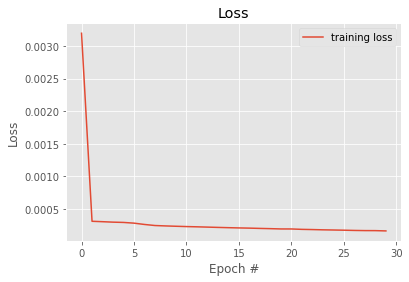

In [3]:
model = Sequential()
model.add(Dense(15, input_shape = (trainX.shape[1],) ,activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1,activation = 'linear'))


opt = SGD(learning_rate = 0.01, momentum = 0.9)
model.compile(loss = 'mean_squared_error', optimizer = opt)


# train the model
maxEpoch = 30
H = model.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)




# plot the loss through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')


plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

34/34 [==============================] - 0s 728us/step


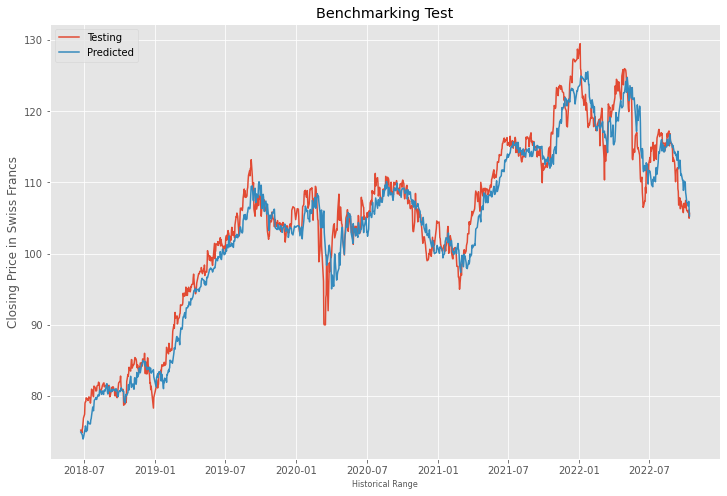

2.153602557985083

In [4]:
predictedClose = model.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction['Predicted Close Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Price in Swiss Francs', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Close', 'Predicted Close Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Close'] - time_prediction['Predicted Close Price'])
time_prediction
time_prediction['diff'].mean()

Just as we thought, much better. We have already decreased the absolute mean error down about 9 CHF! Still, I believe we can have a much better model. We will keep ReLu for now, maybe at the end test it against tanh (just to make sure) but otherwise, let's tinker with some other hyperparameters. 

Regarding our loss function, we really have three others at our disposal for a regression problem like ours: Mean Squared Logarithmic Error, Mean Absolute Error and Huber. I reject using Logarithmic error since our data values are already scaled. Mean Absolute Error could potentially perform better since our data is prone to outlier events (dotcom bust, COVID-19 Market Crash, Global Recession). We'll test out MAE at the end so we don't confuse better performance for something else though, so let's keep it in the back of our mind for now. Additionally, we'll try out Huber loss as this takes the good from both MSE and MAE- which I propose will lead to the best results as we want to capture both regular trends in standard market conditions as well as outlier events like a recession.

Let's add more hidden layers and neurons, see if we overfit worse, and then we can tinker with regularization methods to try to bring that down. Since our data is not very complex, I am not convinced that increasing architecture will lead to better performance, but it would be a shame if we never tried to make our neural net deeper, wouldn't it?

In [3]:
data = yf.download("NESN.SW", start="1999-03-02", end="2022-10-15")
data.to_csv('Nestle CSV')
data= data.dropna()
data = data[['Close']] #filter out other column data
closeVals = data.values #turn our data to numpy array for manipulation
train = math.floor(len(closeVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense)
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(closeVals) #scale data to help with gradient descent
scaledVals
seqdays = 30  #number of days used to construct next day price
monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTest = scaledVals[train - seqdays: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  closeVals[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%
for i in range(seqdays, len(monthTrain)):       #30 to length of rows
    trainX.append(monthTrain[i-seqdays:i, 0])   #creates sequence for 30 days training , take close column with us
    trainY.append(monthTrain[i, 0])             # creates output sequence
for i in range(30,len(monthTest)):
    testX.append(monthTest[i-seqdays:i,0])
trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists arrays for numpy
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       

[*********************100%***********************]  1 of 1 completed


Epoch 1/30
135/135 [==============================] - 1s 919us/step - loss: 5.9532e-04
Epoch 2/30
135/135 [==============================] - 0s 889us/step - loss: 9.6672e-05
Epoch 3/30
135/135 [==============================] - 0s 919us/step - loss: 9.4852e-05
Epoch 4/30
135/135 [==============================] - 0s 874us/step - loss: 9.2895e-05
Epoch 5/30
135/135 [==============================] - 0s 874us/step - loss: 9.4594e-05
Epoch 6/30
135/135 [==============================] - 0s 874us/step - loss: 9.2452e-05
Epoch 7/30
135/135 [==============================] - 0s 956us/step - loss: 9.1739e-05
Epoch 8/30
135/135 [==============================] - 0s 1ms/step - loss: 9.1683e-05
Epoch 9/30
135/135 [==============================] - 0s 971us/step - loss: 8.9935e-05
Epoch 10/30
135/135 [==============================] - 0s 919us/step - loss: 9.0625e-05
Epoch 11/30
135/135 [==============================] - 0s 889us/step - loss: 8.9359e-05
Epoch 12/30
135/135 [======================

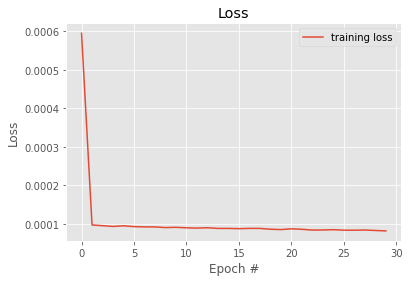

In [4]:
model = Sequential()
model.add(Dense(30, input_shape = (trainX.shape[1],) ,activation = 'relu'))
model.add(Dense(15, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
model.add(Dense(1,activation = 'linear'))
opt = SGD(learning_rate = 0.01, momentum = 0.9)
model.compile(loss = 'mean_squared_error', optimizer = opt)
# train the model
maxEpoch = 30
H = model.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)
# plot the loss through training
plt.style.use('ggplot')
plt.figure()
plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

34/34 [==============================] - 0s 789us/step


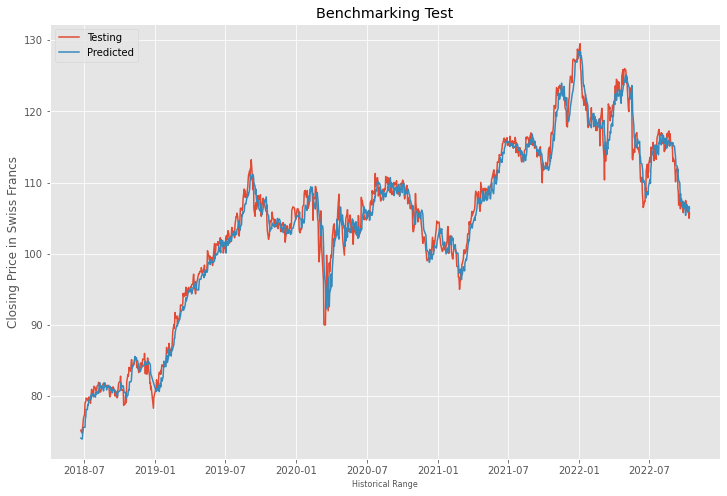

1.3493371733636514

In [5]:
predictedClose = model.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction['Predicted Close Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Price in Swiss Francs', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Close', 'Predicted Close Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Close'] - time_prediction['Predicted Close Price'])
time_prediction
time_prediction['diff'].mean()

Ok, that almost halved our mean absolute error. We move on to regularization where we will consider three separate methods: L1, L2, and Dropout. We will try them all, although I believe a case can be made for L2 since we can think that each day's closing price is somewhat connected to the past and future days (they are probably pretty close in value).

In [2]:
data = yf.download("NESN.SW", start="1999-03-02", end="2022-10-15")
data.to_csv('Nestle CSV')
data= data.dropna()
data = data[['Close']] #filter out other column data
closeVals = data.values #turn our data to numpy array for manipulation
train = math.floor(len(closeVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense)
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(closeVals) #scale data to help with gradient descent
scaledVals
seqdays = 30  #number of days used to construct next day price
monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTest = scaledVals[train - seqdays: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  closeVals[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%
for i in range(seqdays, len(monthTrain)):       #30 to length of rows
    trainX.append(monthTrain[i-seqdays:i, 0])   #creates sequence for 30 days training , take close column with us
    trainY.append(monthTrain[i, 0])             # creates output sequence
for i in range(30,len(monthTest)):
    testX.append(monthTest[i-seqdays:i,0])
trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists arrays for numpy
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       

[*********************100%***********************]  1 of 1 completed


Epoch 1/30
135/135 [==============================] - 1s 956us/step - loss: 0.0295
Epoch 2/30
135/135 [==============================] - 0s 919us/step - loss: 0.0143
Epoch 3/30
135/135 [==============================] - 0s 904us/step - loss: 0.0040
Epoch 4/30
135/135 [==============================] - 0s 896us/step - loss: 0.0039
Epoch 5/30
135/135 [==============================] - 0s 889us/step - loss: 0.0039
Epoch 6/30
135/135 [==============================] - 0s 911us/step - loss: 0.0039
Epoch 7/30
135/135 [==============================] - 0s 904us/step - loss: 0.0039
Epoch 8/30
135/135 [==============================] - 0s 859us/step - loss: 0.0039
Epoch 9/30
135/135 [==============================] - 0s 889us/step - loss: 0.0039
Epoch 10/30
135/135 [==============================] - 0s 889us/step - loss: 0.0039
Epoch 11/30
135/135 [==============================] - 0s 919us/step - loss: 0.0039
Epoch 12/30
135/135 [==============================] - 0s 904us/step - loss: 0.0039
E

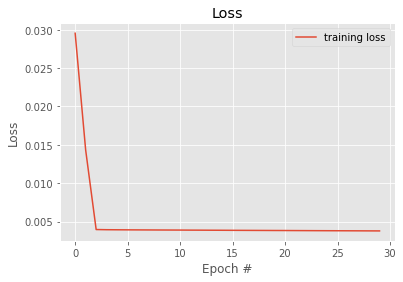

In [5]:
model = Sequential()
model.add(Dense(30, input_shape = (trainX.shape[1],) , kernel_regularizer = l1_l2(l1 = 0.00001, l2 = 0.00001),  activation = 'relu'))
model.add(Dense(15, kernel_regularizer = l1_l2(l1 = 0.00001, l2 = 0.00001), activation = 'relu'))
model.add(Dense(10, kernel_regularizer = l1_l2(l1 = 0.00001, l2 = 0.00001), activation = 'relu'))
model.add(Dense(8, kernel_regularizer = l1_l2(l1 = 0.00001, l2 =0.00001),  activation = 'relu'))
model.add(Dense(4, kernel_regularizer = l1_l2(l1 = 0.00001, l2 = 0.00001),  activation = 'relu'))
model.add(Dense(1,kernel_regularizer = l1_l2(l1 = 0.00001, l2 = 0.00001), activation = 'linear'))
opt = SGD(learning_rate = 0.01, momentum = 0.9)
model.compile(loss = 'mean_squared_error', optimizer = opt)
# train the model
maxEpoch = 30
H = model.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)
# plot the loss through training
plt.style.use('ggplot')
plt.figure()
plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()



34/34 [==============================] - 0s 758us/step


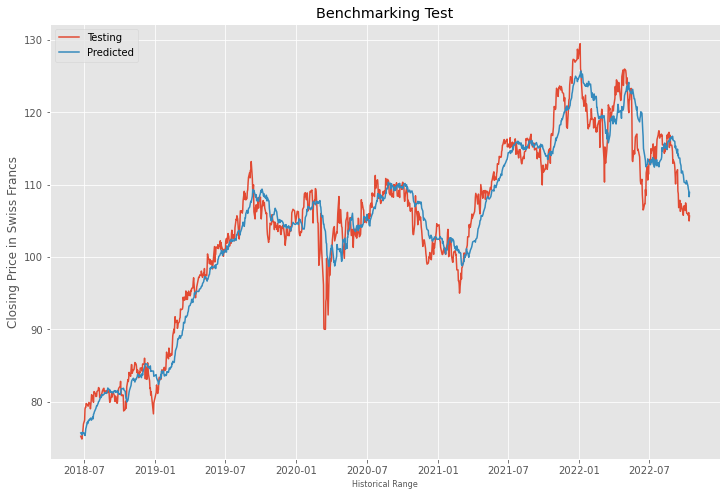

2.1798315460570055

In [6]:
predictedClose = model.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction['Predicted Close Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Price in Swiss Francs', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Close', 'Predicted Close Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Close'] - time_prediction['Predicted Close Price'])
time_prediction
time_prediction['diff'].mean()

Quite unsatisfingly, none of my regularization methods improved performance better than our previous model. I tried all three and combinations- L1, L2, L1 and L2, and Dropout. The best performers were L1 and L2 together, I kept the best regularization performer above and discarded the rest of the experiments for clarity. It seems our data is not quite colinear or just complex enough for regularization methods to help us with overfitting.

Now we can move on to initialization methods. Fortunately, the "He" weight initialization method was created with ReLu in mind (source B). This leads us to use this to improve our model, as opposed to Random weight initialization.


Source B - https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/

In [2]:
data = yf.download("NESN.SW", start="1999-03-02", end="2022-10-15")
data.to_csv('Nestle CSV')
data= data.dropna()
data = data[['Close']] #filter out other column data
closeVals = data.values #turn our data to numpy array for manipulation
train = math.floor(len(closeVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense)
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(closeVals) #scale data to help with gradient descent
scaledVals
seqdays = 30  #number of days used to construct next day price
monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTest = scaledVals[train - seqdays: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  closeVals[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%
for i in range(seqdays, len(monthTrain)):       #30 to length of rows
    trainX.append(monthTrain[i-seqdays:i, 0])   #creates sequence for 30 days training , take close column with us
    trainY.append(monthTrain[i, 0])             # creates output sequence
for i in range(30,len(monthTest)):
    testX.append(monthTest[i-seqdays:i,0])
trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists arrays for numpy
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       

[*********************100%***********************]  1 of 1 completed


Epoch 1/30
135/135 [==============================] - 1s 926us/step - loss: 0.0108
Epoch 2/30
135/135 [==============================] - 0s 934us/step - loss: 1.2702e-04
Epoch 3/30
135/135 [==============================] - 0s 889us/step - loss: 1.1963e-04
Epoch 4/30
135/135 [==============================] - 0s 911us/step - loss: 1.1603e-04
Epoch 5/30
135/135 [==============================] - 0s 889us/step - loss: 1.1434e-04
Epoch 6/30
135/135 [==============================] - 0s 889us/step - loss: 1.1176e-04
Epoch 7/30
135/135 [==============================] - 0s 911us/step - loss: 1.1476e-04
Epoch 8/30
135/135 [==============================] - 0s 896us/step - loss: 1.1045e-04
Epoch 9/30
135/135 [==============================] - 0s 926us/step - loss: 1.1368e-04
Epoch 10/30
135/135 [==============================] - 0s 896us/step - loss: 1.1119e-04
Epoch 11/30
135/135 [==============================] - 0s 949us/step - loss: 1.0847e-04
Epoch 12/30
135/135 [========================

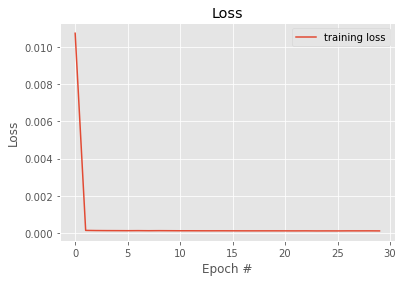

In [3]:
model = Sequential()
model.add(Dense(30, input_shape = (trainX.shape[1],), kernel_initializer = HeUniform(), bias_initializer = HeUniform() ,activation = 'relu'))
model.add(Dense(15,kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(10,kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(8,kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(4,kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(1,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),activation = 'linear'))
opt = SGD(learning_rate = 0.01, momentum = 0.9)
model.compile(loss = 'mean_squared_error', optimizer = opt)
# train the model
maxEpoch = 30
H = model.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)
# plot the loss through training
plt.style.use('ggplot')
plt.figure()
plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

34/34 [==============================] - 0s 1ms/step


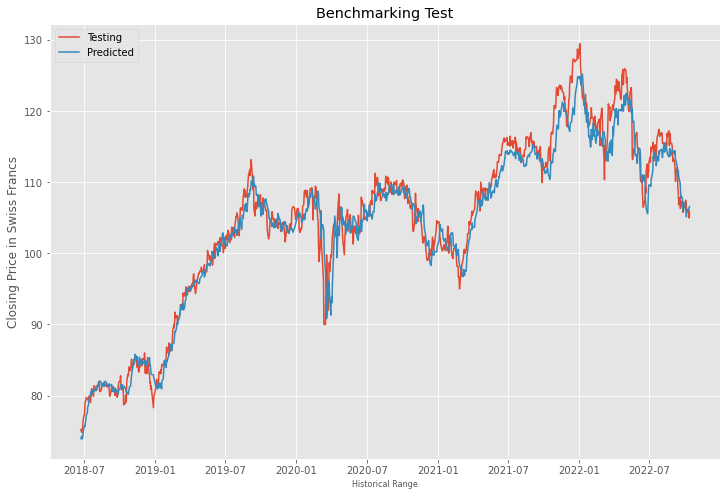

1.7867844484218678

In [4]:
predictedClose = model.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction['Predicted Close Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Price in Swiss Francs', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Close', 'Predicted Close Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Close'] - time_prediction['Predicted Close Price'])
time_prediction
time_prediction['diff'].mean()

Our overall error was worse, although I find He initialization promising because it seems to be more accurate to incremental changes of the share price. I think some further tuning with other ideas might yield better results. Let's try to drop the bias initializer and then see if some regularization helps any (just to put regularization to rest).

Epoch 1/30
135/135 [==============================] - 1s 1ms/step - loss: 0.0065
Epoch 2/30
135/135 [==============================] - 0s 1ms/step - loss: 3.5926e-04
Epoch 3/30
135/135 [==============================] - 0s 2ms/step - loss: 2.9839e-04
Epoch 4/30
135/135 [==============================] - 0s 2ms/step - loss: 2.7518e-04
Epoch 5/30
135/135 [==============================] - 0s 2ms/step - loss: 2.5004e-04
Epoch 6/30
135/135 [==============================] - 0s 2ms/step - loss: 2.3400e-04
Epoch 7/30
135/135 [==============================] - 0s 2ms/step - loss: 2.2265e-04
Epoch 8/30
135/135 [==============================] - 0s 2ms/step - loss: 1.9275e-04
Epoch 9/30
135/135 [==============================] - 0s 2ms/step - loss: 1.9081e-04
Epoch 10/30
135/135 [==============================] - 0s 2ms/step - loss: 1.8397e-04
Epoch 11/30
135/135 [==============================] - 0s 2ms/step - loss: 1.7303e-04
Epoch 12/30
135/135 [==============================] - 0s 2ms/step 

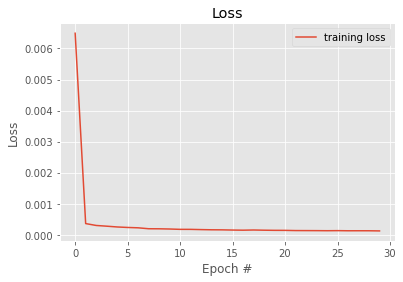

In [5]:
model = Sequential()
model.add(Dense(30, input_shape = (trainX.shape[1],), kernel_initializer = HeUniform() ,activation = 'relu'))
model.add(Dense(15,kernel_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(10,kernel_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(8,kernel_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(4,kernel_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(1,kernel_initializer = HeUniform(),activation = 'linear'))
opt = SGD(learning_rate = 0.01, momentum = 0.9)
model.compile(loss = 'mean_squared_error', optimizer = opt)
# train the model
maxEpoch = 30
H = model.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)
# plot the loss through training
plt.style.use('ggplot')
plt.figure()
plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

34/34 [==============================] - 0s 758us/step


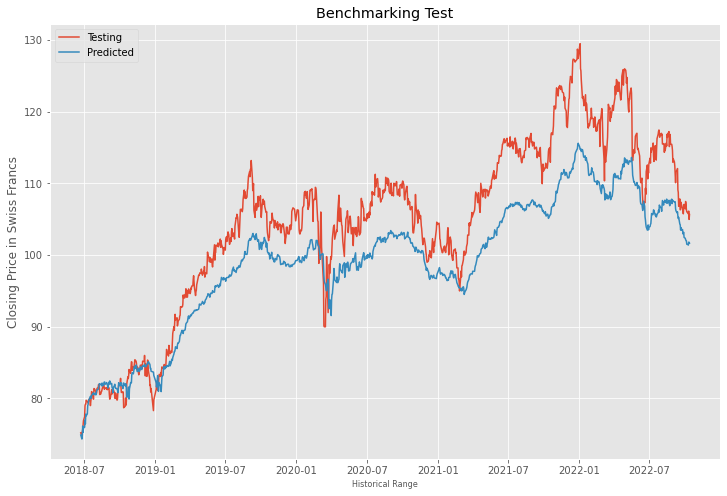

5.750164660161641

In [6]:
predictedClose = model.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction['Predicted Close Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Price in Swiss Francs', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Close', 'Predicted Close Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Close'] - time_prediction['Predicted Close Price'])
time_prediction
time_prediction['diff'].mean()

Epoch 1/30
135/135 [==============================] - 1s 3ms/step - loss: 0.1625
Epoch 2/30
135/135 [==============================] - 0s 2ms/step - loss: 0.1583
Epoch 3/30
135/135 [==============================] - 0s 2ms/step - loss: 0.1579
Epoch 4/30
135/135 [==============================] - 0s 2ms/step - loss: 0.1576
Epoch 5/30
135/135 [==============================] - 0s 2ms/step - loss: 0.1572
Epoch 6/30
135/135 [==============================] - 0s 3ms/step - loss: 0.1569
Epoch 7/30
135/135 [==============================] - 1s 4ms/step - loss: 0.1565
Epoch 8/30
135/135 [==============================] - 1s 4ms/step - loss: 0.1562
Epoch 9/30
135/135 [==============================] - 1s 4ms/step - loss: 0.1558
Epoch 10/30
135/135 [==============================] - 1s 4ms/step - loss: 0.1555
Epoch 11/30
135/135 [==============================] - 1s 4ms/step - loss: 0.1552
Epoch 12/30
135/135 [==============================] - 1s 4ms/step - loss: 0.1548
Epoch 13/30
135/135 [====

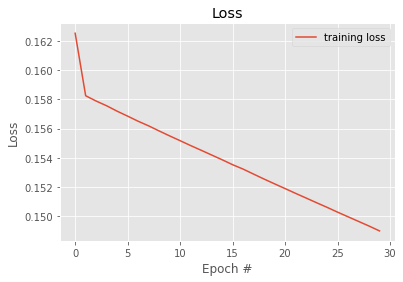

In [3]:
model = Sequential()
model.add(Dense(500, input_shape = (trainX.shape[1],) , kernel_initializer = HeUniform(), bias_initializer = HeUniform(), kernel_regularizer = l1_l2(l1 = 0.00001, l2 = 0.00001),  activation = 'relu'))
model.add(Dense(250,kernel_initializer = HeUniform(), bias_initializer = HeUniform(), kernel_regularizer = l1_l2(l1 = 0.00001, l2 = 0.00001), activation = 'relu'))
model.add(Dense(125,kernel_initializer = HeUniform(), bias_initializer = HeUniform(), kernel_regularizer = l1_l2(l1 = 0.00001, l2 = 0.00001), activation = 'relu'))
model.add(Dense(75,kernel_initializer = HeUniform(), bias_initializer = HeUniform(), kernel_regularizer = l1_l2(l1 = 0.00001, l2 =0.00001),  activation = 'relu'))
model.add(Dense(25,kernel_initializer = HeUniform(), bias_initializer = HeUniform(), kernel_regularizer = l1_l2(l1 = 0.00001, l2 = 0.00001),  activation = 'relu'))
model.add(Dense(1,kernel_initializer = HeUniform(), bias_initializer = HeUniform(), kernel_regularizer = l1_l2(l1 = 0.00001, l2 = 0.00001), activation = 'linear'))
opt = SGD(learning_rate = 0.01, momentum = 0.9)
model.compile(loss = 'mean_squared_error', optimizer = opt)
# train the model
maxEpoch = 30
H = model.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)
# plot the loss through training
plt.style.use('ggplot')
plt.figure()
plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()



34/34 [==============================] - 0s 3ms/step


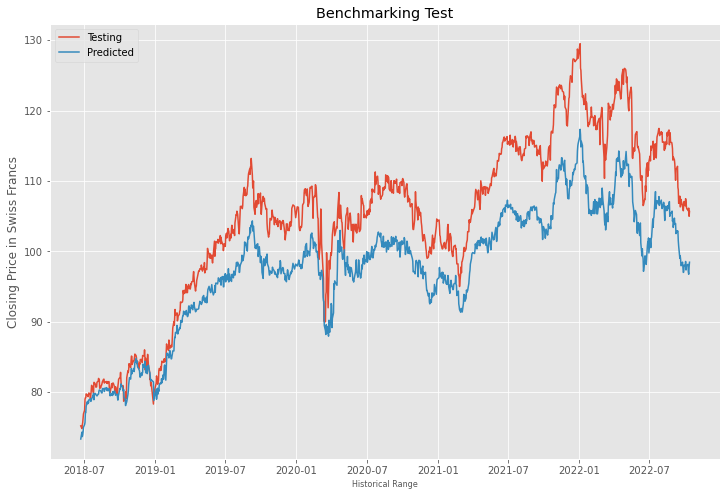

7.014992953443484

In [4]:
predictedClose = model.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction['Predicted Close Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Price in Swiss Francs', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Close', 'Predicted Close Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Close'] - time_prediction['Predicted Close Price'])
time_prediction
time_prediction['diff'].mean()

Dropping the bias initializer made things worse, so we'll keep that in there. With L1 and L2 penalties we also had no luck. Notice we made the network wider. Let's try a larger network with more neurons as before but only keeping our promising He initialization with us.

In [2]:
data = yf.download("NESN.SW", start="1999-03-02", end="2022-10-15")
data.to_csv('Nestle CSV')
data= data.dropna()
data = data[['Close']] #filter out other column data
closeVals = data.values #turn our data to numpy array for manipulation
train = math.floor(len(closeVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense)
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(closeVals) #scale data to help with gradient descent
scaledVals
seqdays = 30  #number of days used to construct next day price
monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTest = scaledVals[train - seqdays: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  closeVals[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%
for i in range(seqdays, len(monthTrain)):       #30 to length of rows
    trainX.append(monthTrain[i-seqdays:i, 0])   #creates sequence for 30 days training , take close column with us
    trainY.append(monthTrain[i, 0])             # creates output sequence
for i in range(30,len(monthTest)):
    testX.append(monthTest[i-seqdays:i,0])
trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists arrays for numpy
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       

[*********************100%***********************]  1 of 1 completed


Epoch 1/30
135/135 [==============================] - 1s 5ms/step - loss: 0.0073
Epoch 2/30
135/135 [==============================] - 1s 5ms/step - loss: 1.9447e-04
Epoch 3/30
135/135 [==============================] - 1s 5ms/step - loss: 2.0268e-04
Epoch 4/30
135/135 [==============================] - 1s 5ms/step - loss: 1.5827e-04
Epoch 5/30
135/135 [==============================] - 1s 5ms/step - loss: 1.6119e-04
Epoch 6/30
135/135 [==============================] - 1s 5ms/step - loss: 1.2287e-04
Epoch 7/30
135/135 [==============================] - 1s 5ms/step - loss: 1.1708e-04
Epoch 8/30
135/135 [==============================] - 1s 5ms/step - loss: 1.1347e-04
Epoch 9/30
135/135 [==============================] - 1s 5ms/step - loss: 1.1471e-04
Epoch 10/30
135/135 [==============================] - 1s 5ms/step - loss: 1.1421e-04
Epoch 11/30
135/135 [==============================] - 1s 5ms/step - loss: 9.9122e-05
Epoch 12/30
135/135 [==============================] - 1s 5ms/step 

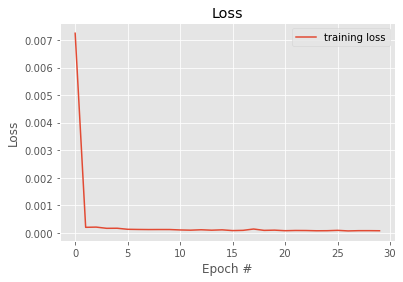

In [7]:
model = Sequential()
model.add(Dense(1000, input_shape = (trainX.shape[1],),kernel_initializer = HeUniform(), bias_initializer = HeUniform() ,activation = 'relu'))
model.add(Dense(500,kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(250, kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(125,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(60,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(1,activation = 'linear'))
opt = SGD(learning_rate = 0.01, momentum = 0.9)
model.compile(loss = 'mean_squared_error', optimizer = opt)
# train the model
maxEpoch = 30
H = model.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)
# plot the loss through training
plt.style.use('ggplot')
plt.figure()
plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

34/34 [==============================] - 0s 2ms/step


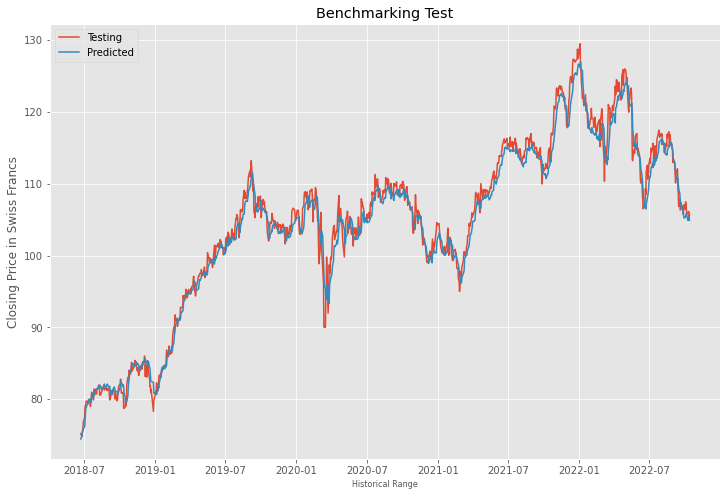

1.2422215059029476

In [8]:
predictedClose = model.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction['Predicted Close Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Price in Swiss Francs', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Close', 'Predicted Close Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Close'] - time_prediction['Predicted Close Price'])
time_prediction
time_prediction['diff'].mean()

Through testing various combinations for He initialization, we have slightly improved the performance of the model (albeit by making the model much wider). However this is useful, since by using these weight initialization we have better performance compared to our previous model with the same number of neurons, as seen below.

Epoch 1/30
135/135 [==============================] - 1s 5ms/step - loss: 0.0044
Epoch 2/30
135/135 [==============================] - 1s 5ms/step - loss: 1.7230e-04
Epoch 3/30
135/135 [==============================] - 1s 5ms/step - loss: 1.6074e-04
Epoch 4/30
135/135 [==============================] - 1s 5ms/step - loss: 1.5121e-04
Epoch 5/30
135/135 [==============================] - 1s 5ms/step - loss: 1.4541e-04
Epoch 6/30
135/135 [==============================] - 1s 5ms/step - loss: 1.3812e-04
Epoch 7/30
135/135 [==============================] - 1s 5ms/step - loss: 1.3358e-04
Epoch 8/30
135/135 [==============================] - 1s 5ms/step - loss: 1.3012e-04
Epoch 9/30
135/135 [==============================] - 1s 5ms/step - loss: 1.2391e-04
Epoch 10/30
135/135 [==============================] - 1s 5ms/step - loss: 1.2167e-04
Epoch 11/30
135/135 [==============================] - 1s 5ms/step - loss: 1.1661e-04
Epoch 12/30
135/135 [==============================] - 1s 5ms/step 

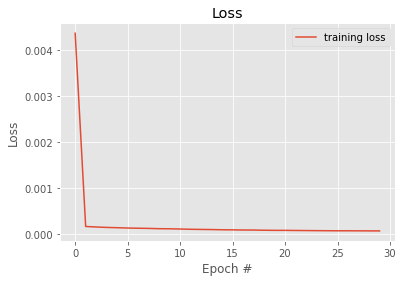

In [3]:
model = Sequential()
model.add(Dense(1000, input_shape = (trainX.shape[1],) ,activation = 'relu'))
model.add(Dense(500, activation = 'relu'))
model.add(Dense(250, activation = 'relu'))
model.add(Dense(125, activation = 'relu'))
model.add(Dense(60, activation = 'relu'))
model.add(Dense(1,activation = 'linear'))
opt = SGD(learning_rate = 0.01, momentum = 0.9)
model.compile(loss = 'mean_squared_error', optimizer = opt)
# train the model
maxEpoch = 30
H = model.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)
# plot the loss through training
plt.style.use('ggplot')
plt.figure()
plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

34/34 [==============================] - 0s 2ms/step


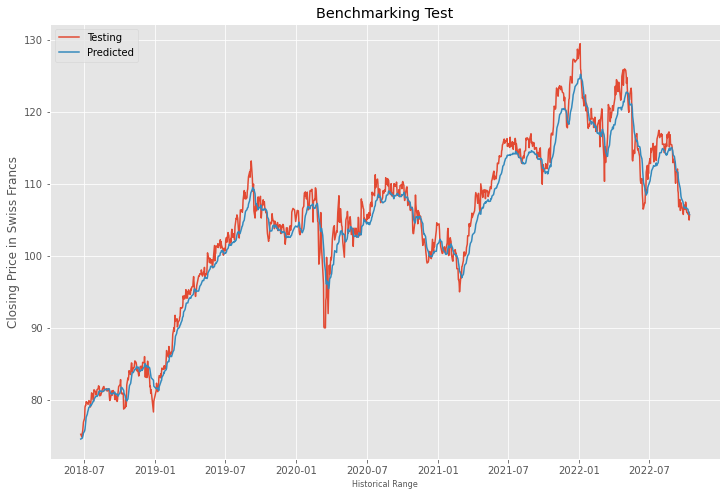

1.6424461301577233

In [4]:
predictedClose = model.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction['Predicted Close Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Price in Swiss Francs', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Close', 'Predicted Close Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Close'] - time_prediction['Predicted Close Price'])
time_prediction
time_prediction['diff'].mean()

We have been using the linear activation function for the last layer since our output is unbounded stock returns. What if we found better results with a different, non-linear activation in the last layer (just to see)?

Epoch 1/30
135/135 [==============================] - 1s 5ms/step - loss: 0.0093
Epoch 2/30
135/135 [==============================] - 1s 5ms/step - loss: 4.3897e-04
Epoch 3/30
135/135 [==============================] - 1s 5ms/step - loss: 2.7699e-04
Epoch 4/30
135/135 [==============================] - 1s 5ms/step - loss: 2.1728e-04
Epoch 5/30
135/135 [==============================] - 1s 5ms/step - loss: 1.8447e-04
Epoch 6/30
135/135 [==============================] - 1s 5ms/step - loss: 1.6006e-04
Epoch 7/30
135/135 [==============================] - 1s 5ms/step - loss: 1.4334e-04
Epoch 8/30
135/135 [==============================] - 1s 5ms/step - loss: 1.3367e-04
Epoch 9/30
135/135 [==============================] - 1s 5ms/step - loss: 1.2298e-04
Epoch 10/30
135/135 [==============================] - 1s 5ms/step - loss: 1.1785e-04
Epoch 11/30
135/135 [==============================] - 1s 5ms/step - loss: 1.0965e-04
Epoch 12/30
135/135 [==============================] - 1s 5ms/step 

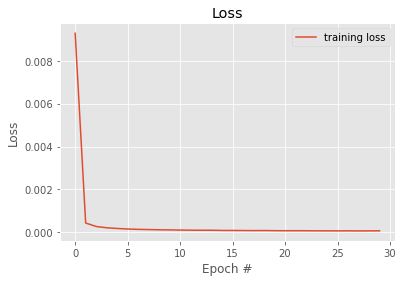

In [3]:
model = Sequential()
model.add(Dense(1000, input_shape = (trainX.shape[1],),kernel_initializer = HeUniform(), bias_initializer = HeUniform() ,activation = 'relu'))
model.add(Dense(500,kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(250, kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(125,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(60,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))
opt = SGD(learning_rate = 0.01, momentum = 0.9)
model.compile(loss = 'mean_squared_error', optimizer = opt)
# train the model
maxEpoch = 30
H = model.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)
# plot the loss through training
plt.style.use('ggplot')
plt.figure()
plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

34/34 [==============================] - 0s 2ms/step


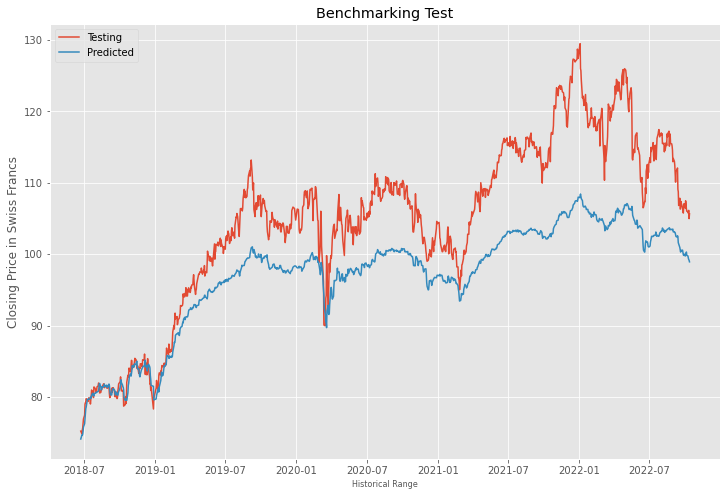

7.66795973089055

In [4]:
predictedClose = model.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction['Predicted Close Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Price in Swiss Francs', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Close', 'Predicted Close Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Close'] - time_prediction['Predicted Close Price'])
time_prediction
time_prediction['diff'].mean()

Okay, we'll keep it linear. Let's see if the great Adam optimizer can better our results in any way, although a literature review leads me to expect we will not see too much progress changing the optimizer (source C and D).

Source C and D: https://opt-ml.org/papers/2021/paper53.pdf
                https://ruder.io/optimizing-gradient-descent/

Epoch 1/30
135/135 [==============================] - 1s 5ms/step - loss: 0.0264
Epoch 2/30
135/135 [==============================] - 1s 5ms/step - loss: 1.3554e-04
Epoch 3/30
135/135 [==============================] - 1s 5ms/step - loss: 0.0019
Epoch 4/30
135/135 [==============================] - 1s 5ms/step - loss: 1.5316e-04
Epoch 5/30
135/135 [==============================] - 1s 5ms/step - loss: 3.6326e-04
Epoch 6/30
135/135 [==============================] - 1s 5ms/step - loss: 1.5236e-04
Epoch 7/30
135/135 [==============================] - 1s 5ms/step - loss: 6.1313e-04
Epoch 8/30
135/135 [==============================] - 1s 5ms/step - loss: 7.0586e-05
Epoch 9/30
135/135 [==============================] - 1s 5ms/step - loss: 2.4174e-04
Epoch 10/30
135/135 [==============================] - 1s 5ms/step - loss: 1.3610e-04
Epoch 11/30
135/135 [==============================] - 1s 6ms/step - loss: 9.4135e-05
Epoch 12/30
135/135 [==============================] - 1s 5ms/step - lo

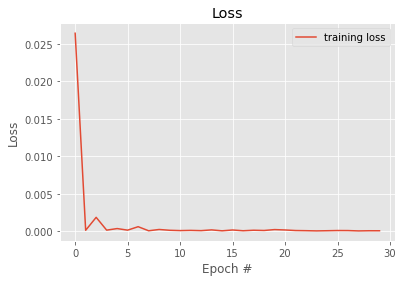

In [3]:
model = Sequential()
model.add(Dense(1000, input_shape = (trainX.shape[1],),kernel_initializer = HeUniform(), bias_initializer = HeUniform() ,activation = 'relu'))
model.add(Dense(500,kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(250, kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(125,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(60,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(1,activation = 'linear'))
#opt = SGD(learning_rate = 0.01, momentum = 0.9)
model.compile(loss = 'mean_squared_error', optimizer = 'Adam')
# train the model
maxEpoch = 30
H = model.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32, verbose = 1)
# plot the loss through training
plt.style.use('ggplot')
plt.figure()
plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

34/34 [==============================] - 0s 2ms/step


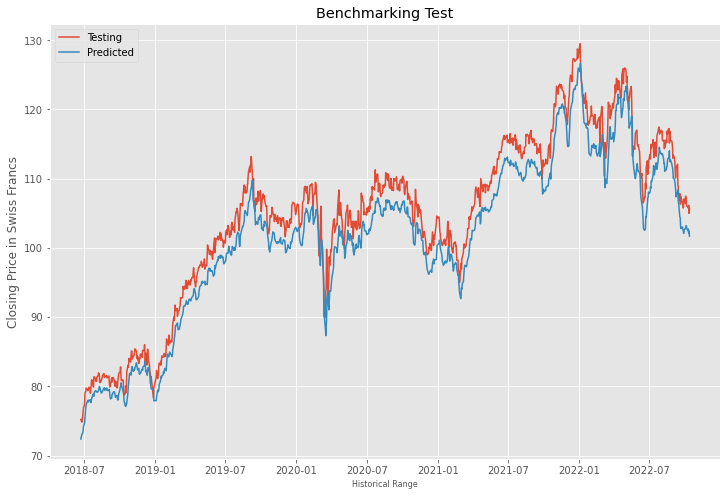

3.136990579641951

In [4]:
predictedClose = model.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction['Predicted Close Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Price in Swiss Francs', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Close', 'Predicted Close Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Close'] - time_prediction['Predicted Close Price'])
time_prediction
time_prediction['diff'].mean()

However, we can try to revert back to SGD and attempt to optimize further with decay and Nesterov Acceleration. Decay here is a time-based learning schedule which will decrease our learning rate as we progress over model. Since I've tested (without showing) a smaller learning rate makes performance worse, I am not positive this initial run will work. However, maybe if we increase the learning rate a bit and use decay again we could have strong results. I will run one test with Nesterov Acceleration, but will not keep it since we evidently have no trouble converging to an extremely slow loss.

Epoch 1/30
135/135 [==============================] - 1s 5ms/step - loss: 0.0073
Epoch 2/30
135/135 [==============================] - 1s 5ms/step - loss: 1.5322e-04
Epoch 3/30
135/135 [==============================] - 1s 5ms/step - loss: 1.5024e-04
Epoch 4/30
135/135 [==============================] - 1s 5ms/step - loss: 1.1913e-04
Epoch 5/30
135/135 [==============================] - 1s 5ms/step - loss: 1.3873e-04
Epoch 6/30
135/135 [==============================] - 1s 5ms/step - loss: 9.8746e-05
Epoch 7/30
135/135 [==============================] - 1s 5ms/step - loss: 1.0545e-04
Epoch 8/30
135/135 [==============================] - 1s 5ms/step - loss: 8.1494e-05
Epoch 9/30
135/135 [==============================] - 1s 5ms/step - loss: 8.9626e-05
Epoch 10/30
135/135 [==============================] - 1s 5ms/step - loss: 8.0373e-05
Epoch 11/30
135/135 [==============================] - 1s 6ms/step - loss: 7.4544e-05
Epoch 12/30
135/135 [==============================] - 1s 5ms/step 

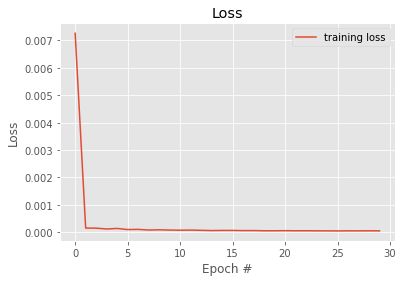

In [3]:
model = Sequential()
model.add(Dense(1000, input_shape = (trainX.shape[1],),kernel_initializer = HeUniform(), bias_initializer = HeUniform() ,activation = 'relu'))
model.add(Dense(500,kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(250, kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(125,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(60,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(1,activation = 'linear'))
opt = SGD(learning_rate = 0.01, decay = 0.01 / 100, momentum = 0.9, nesterov = True)
model.compile(loss = 'mean_squared_error', optimizer = opt)
# train the model
maxEpoch = 30
H = model.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32, verbose = 1)
# plot the loss through training
plt.style.use('ggplot')
plt.figure()
plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

34/34 [==============================] - 0s 2ms/step


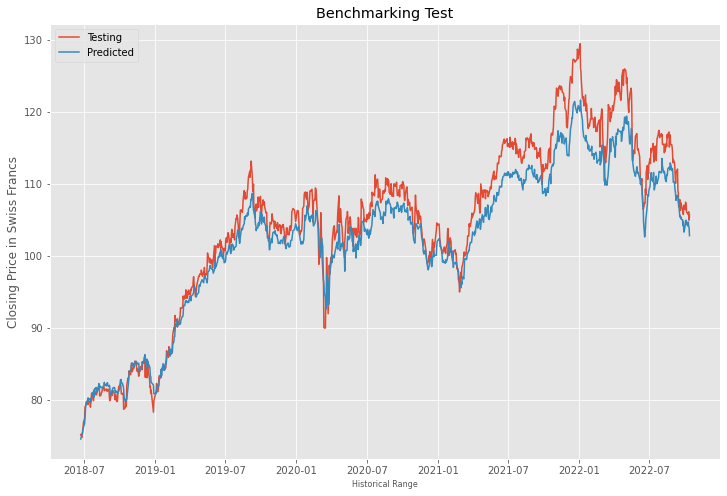

2.6025098784866967

In [4]:
predictedClose = model.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction['Predicted Close Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Price in Swiss Francs', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Close', 'Predicted Close Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Close'] - time_prediction['Predicted Close Price'])
time_prediction
time_prediction['diff'].mean()

Now we'll go for no Nesterov acceleration.

Epoch 1/30
135/135 [==============================] - 1s 5ms/step - loss: 0.0050
Epoch 2/30
135/135 [==============================] - 1s 5ms/step - loss: 2.1426e-04
Epoch 3/30
135/135 [==============================] - 1s 5ms/step - loss: 1.3710e-04
Epoch 4/30
135/135 [==============================] - 1s 5ms/step - loss: 1.1639e-04
Epoch 5/30
135/135 [==============================] - 1s 5ms/step - loss: 1.0649e-04
Epoch 6/30
135/135 [==============================] - 1s 5ms/step - loss: 1.1690e-04
Epoch 7/30
135/135 [==============================] - 1s 5ms/step - loss: 8.7443e-05
Epoch 8/30
135/135 [==============================] - 1s 5ms/step - loss: 1.0317e-04
Epoch 9/30
135/135 [==============================] - 1s 5ms/step - loss: 8.5969e-05
Epoch 10/30
135/135 [==============================] - 1s 5ms/step - loss: 8.4463e-05
Epoch 11/30
135/135 [==============================] - 1s 5ms/step - loss: 9.7381e-05
Epoch 12/30
135/135 [==============================] - 1s 5ms/step 

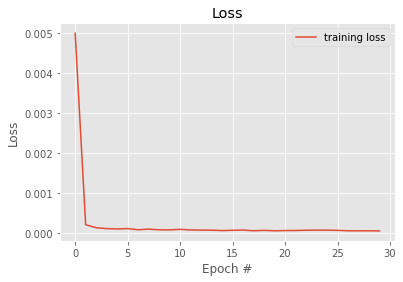

In [3]:
model = Sequential()
model.add(Dense(1000, input_shape = (trainX.shape[1],),kernel_initializer = HeUniform(), bias_initializer = HeUniform() ,activation = 'relu'))
model.add(Dense(500,kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(250, kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(125,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(60,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(1,activation = 'linear'))
opt = SGD(learning_rate = 0.015, decay = 0.01 / 100, momentum = 0.9, nesterov = False)
model.compile(loss = 'mean_squared_error', optimizer = opt)
# train the model
maxEpoch = 30
H = model.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32, verbose = 1)
# plot the loss through training
plt.style.use('ggplot')
plt.figure()
plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

34/34 [==============================] - 0s 2ms/step


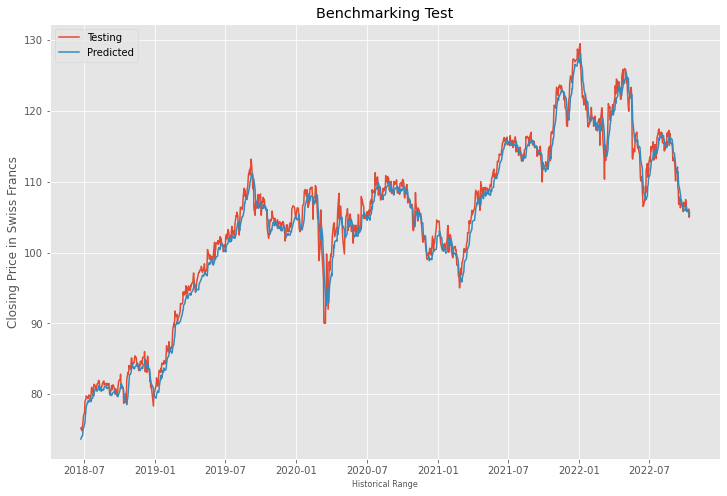

1.250192103521914

In [4]:
predictedClose = model.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction['Predicted Close Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Price in Swiss Francs', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Close', 'Predicted Close Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Close'] - time_prediction['Predicted Close Price'])
time_prediction
time_prediction['diff'].mean()

Scheduling doesn't seem to change much with regards to improving our model, although these experiments (particularly the last one because of the fit) have led me to believe that taking out scheduling but perturbing our learning rate might help us reach better performance. Maybe we just need to find a sweet spot with our learning rate. 

Epoch 1/30
135/135 [==============================] - 1s 5ms/step - loss: 0.0203
Epoch 2/30
135/135 [==============================] - 1s 5ms/step - loss: 1.6605e-04
Epoch 3/30
135/135 [==============================] - 1s 5ms/step - loss: 1.4994e-04
Epoch 4/30
135/135 [==============================] - 1s 5ms/step - loss: 1.3767e-04
Epoch 5/30
135/135 [==============================] - 1s 5ms/step - loss: 1.2883e-04
Epoch 6/30
135/135 [==============================] - 1s 5ms/step - loss: 1.3910e-04
Epoch 7/30
135/135 [==============================] - 1s 5ms/step - loss: 1.2431e-04
Epoch 8/30
135/135 [==============================] - 1s 5ms/step - loss: 1.0407e-04
Epoch 9/30
135/135 [==============================] - 1s 5ms/step - loss: 1.0478e-04
Epoch 10/30
135/135 [==============================] - 1s 5ms/step - loss: 8.8193e-05
Epoch 11/30
135/135 [==============================] - 1s 5ms/step - loss: 9.3108e-05
Epoch 12/30
135/135 [==============================] - 1s 5ms/step 

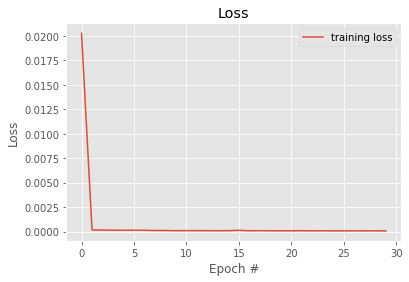

In [3]:
model = Sequential()
model.add(Dense(1000, input_shape = (trainX.shape[1],),kernel_initializer = HeUniform(), bias_initializer = HeUniform() ,activation = 'relu'))
model.add(Dense(500,kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(250, kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(125,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(60,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(1,activation = 'linear'))
opt = SGD(learning_rate = 0.015, momentum = 0.9)
model.compile(loss = 'mean_squared_error', optimizer = opt)
# train the model
maxEpoch = 30
H = model.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)
# plot the loss through training
plt.style.use('ggplot')
plt.figure()
plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

34/34 [==============================] - 0s 2ms/step


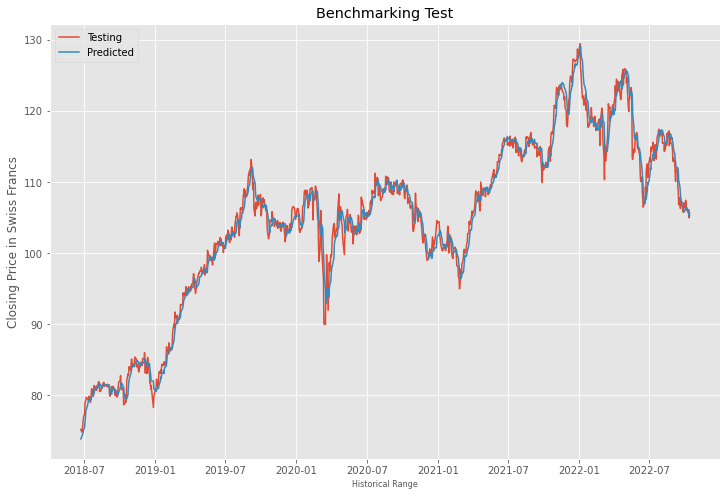

1.133198040608649

In [4]:
predictedClose = model.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction['Predicted Close Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Price in Swiss Francs', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Close', 'Predicted Close Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Close'] - time_prediction['Predicted Close Price'])
time_prediction
time_prediction['diff'].mean()

Finally a breakthrough, it seems like our learning rate has been holding us back. Further perturbations around a = 0.015 did not yield anything better, so it really seems like this is the sweet spot.

Let's run with some different loss functions. We previously talked about the chance that Mean Absolute error could be worthwhile, so we'll give that a go first. Next we'll try Huber loss and see how it compares, since this loss function allows us to take some sensitivity to outliers in the market (MSE) and also worry about the regular majority of days without outlier prices (MAE).

Epoch 1/30
135/135 [==============================] - 1s 5ms/step - loss: 0.0901
Epoch 2/30
135/135 [==============================] - 1s 5ms/step - loss: 0.0201
Epoch 3/30
135/135 [==============================] - 1s 5ms/step - loss: 0.0165
Epoch 4/30
135/135 [==============================] - 1s 5ms/step - loss: 0.0161
Epoch 5/30
135/135 [==============================] - 1s 5ms/step - loss: 0.0122
Epoch 6/30
135/135 [==============================] - 1s 5ms/step - loss: 0.0149
Epoch 7/30
135/135 [==============================] - 1s 5ms/step - loss: 0.0147
Epoch 8/30
135/135 [==============================] - 1s 5ms/step - loss: 0.0109
Epoch 9/30
135/135 [==============================] - 1s 5ms/step - loss: 0.0175
Epoch 10/30
135/135 [==============================] - 1s 5ms/step - loss: 0.0164
Epoch 11/30
135/135 [==============================] - 1s 5ms/step - loss: 0.0138
Epoch 12/30
135/135 [==============================] - 1s 5ms/step - loss: 0.0145
Epoch 13/30
135/135 [====

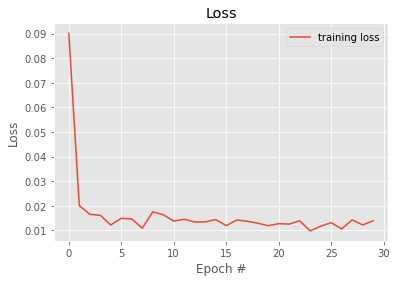

In [3]:
model = Sequential()
model.add(Dense(1000, input_shape = (trainX.shape[1],),kernel_initializer = HeUniform(), bias_initializer = HeUniform() ,activation = 'relu'))
model.add(Dense(500,kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(250, kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(125,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(60,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(1,activation = 'linear'))
opt = SGD(learning_rate = 0.015, momentum = 0.9)
model.compile(loss = 'mean_absolute_error', optimizer = opt)
# train the model
maxEpoch = 30
H = model.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)
# plot the loss through training
plt.style.use('ggplot')
plt.figure()
plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

34/34 [==============================] - 0s 2ms/step


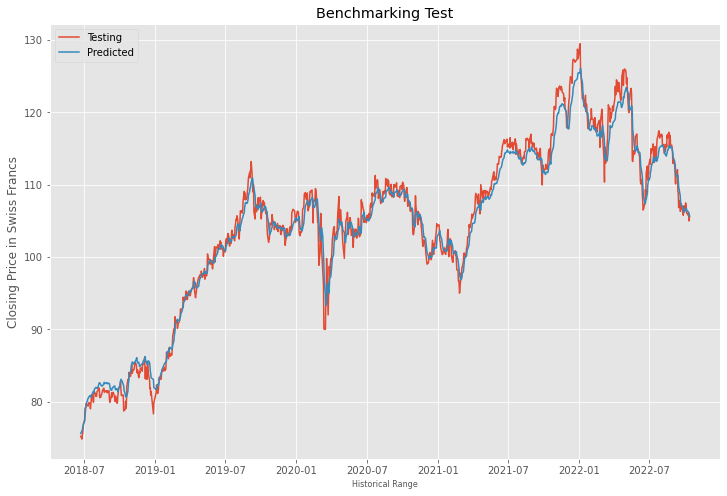

1.2580417327740485

In [4]:
predictedClose = model.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction['Predicted Close Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Price in Swiss Francs', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Close', 'Predicted Close Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Close'] - time_prediction['Predicted Close Price'])
time_prediction
time_prediction['diff'].mean()

Epoch 1/30
135/135 [==============================] - 1s 5ms/step - loss: 0.0014
Epoch 2/30
135/135 [==============================] - 1s 5ms/step - loss: 6.7751e-05
Epoch 3/30
135/135 [==============================] - 1s 5ms/step - loss: 6.8336e-05
Epoch 4/30
135/135 [==============================] - 1s 5ms/step - loss: 5.3419e-05
Epoch 5/30
135/135 [==============================] - 1s 5ms/step - loss: 4.9267e-05
Epoch 6/30
135/135 [==============================] - 1s 5ms/step - loss: 4.4664e-05
Epoch 7/30
135/135 [==============================] - 1s 5ms/step - loss: 5.8596e-05
Epoch 8/30
135/135 [==============================] - 1s 5ms/step - loss: 4.2088e-05
Epoch 9/30
135/135 [==============================] - 1s 5ms/step - loss: 4.0394e-05
Epoch 10/30
135/135 [==============================] - 1s 5ms/step - loss: 4.1225e-05
Epoch 11/30
135/135 [==============================] - 1s 5ms/step - loss: 4.9216e-05
Epoch 12/30
135/135 [==============================] - 1s 5ms/step 

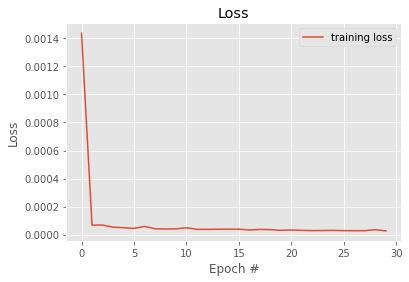

In [3]:
model = Sequential()
model.add(Dense(1000, input_shape = (trainX.shape[1],),kernel_initializer = HeUniform(), bias_initializer = HeUniform() ,activation = 'relu'))
model.add(Dense(500,kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(250, kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(125,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(60,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(1,activation = 'linear'))
opt = SGD(learning_rate = 0.015, momentum = 0.9)
model.compile(loss = 'huber_loss', optimizer = opt)
# train the model
maxEpoch = 30
H = model.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)
# plot the loss through training
plt.style.use('ggplot')
plt.figure()
plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

34/34 [==============================] - 0s 2ms/step


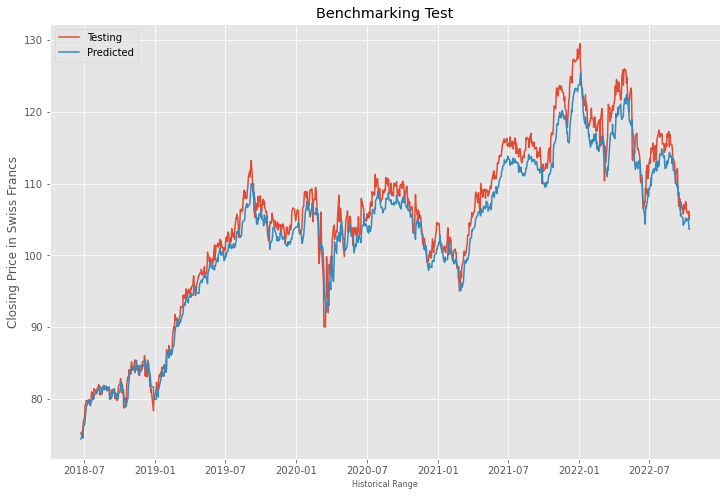

1.9928298641369775

In [4]:
predictedClose = model.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction['Predicted Close Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Price in Swiss Francs', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Close', 'Predicted Close Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Close'] - time_prediction['Predicted Close Price'])
time_prediction
time_prediction['diff'].mean()

Mean Absolute Error did not perform as well (but not bad), and Huber loss was actually worse for fitting, but if we look at the loss on the Huber model we can see it is lower than anything seen before. This gives me hope that if we train it over longer epochs we can optimize better than our MSE model. We'll run both over 75 epochs and see how they compare. 

Epoch 1/75
135/135 [==============================] - 1s 5ms/step - loss: 0.0072
Epoch 2/75
135/135 [==============================] - 1s 5ms/step - loss: 2.1189e-04
Epoch 3/75
135/135 [==============================] - 1s 5ms/step - loss: 1.7307e-04
Epoch 4/75
135/135 [==============================] - 1s 5ms/step - loss: 1.4848e-04
Epoch 5/75
135/135 [==============================] - 1s 5ms/step - loss: 1.3715e-04
Epoch 6/75
135/135 [==============================] - 1s 5ms/step - loss: 1.1887e-04
Epoch 7/75
135/135 [==============================] - 1s 5ms/step - loss: 1.0198e-04
Epoch 8/75
135/135 [==============================] - 1s 5ms/step - loss: 9.7190e-05
Epoch 9/75
135/135 [==============================] - 1s 5ms/step - loss: 9.2571e-05
Epoch 10/75
135/135 [==============================] - 1s 5ms/step - loss: 8.6910e-05
Epoch 11/75
135/135 [==============================] - 1s 5ms/step - loss: 7.9209e-05
Epoch 12/75
135/135 [==============================] - 1s 5ms/step 

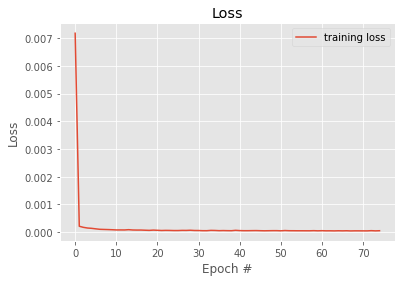

In [3]:
model = Sequential()
model.add(Dense(1000, input_shape = (trainX.shape[1],),kernel_initializer = HeUniform(), bias_initializer = HeUniform() ,activation = 'relu'))
model.add(Dense(500,kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(250, kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(125,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(60,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(1,activation = 'linear'))
opt = SGD(learning_rate = 0.015, momentum = 0.9)
model.compile(loss = 'mean_squared_error', optimizer = opt)
# train the model
maxEpoch = 75
H = model.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)
# plot the loss through training
plt.style.use('ggplot')
plt.figure()
plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

34/34 [==============================] - 0s 2ms/step


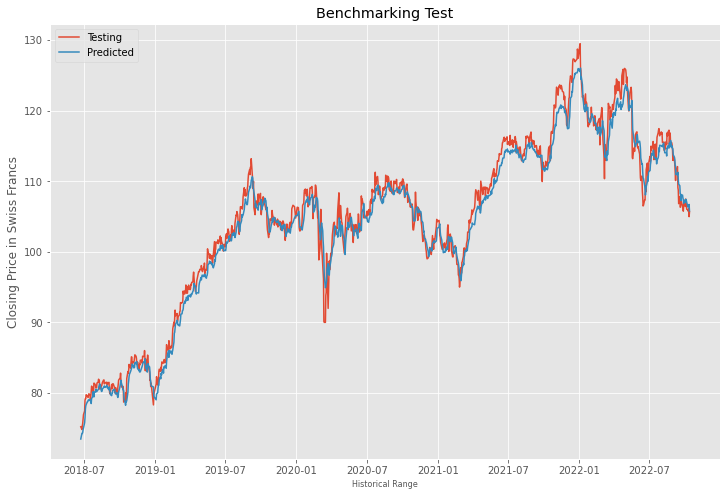

1.3532782715180651

In [4]:
predictedClose = model.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction['Predicted Close Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Price in Swiss Francs', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Close', 'Predicted Close Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Close'] - time_prediction['Predicted Close Price'])
time_prediction
time_prediction['diff'].mean()

Epoch 1/75
135/135 [==============================] - 1s 5ms/step - loss: 0.0018
Epoch 2/75
135/135 [==============================] - 1s 6ms/step - loss: 6.1732e-05
Epoch 3/75
135/135 [==============================] - 1s 5ms/step - loss: 5.0421e-05
Epoch 4/75
135/135 [==============================] - 1s 5ms/step - loss: 4.5906e-05
Epoch 5/75
135/135 [==============================] - 1s 5ms/step - loss: 4.3059e-05
Epoch 6/75
135/135 [==============================] - 1s 5ms/step - loss: 3.8817e-05
Epoch 7/75
135/135 [==============================] - 1s 5ms/step - loss: 3.9356e-05
Epoch 8/75
135/135 [==============================] - 1s 5ms/step - loss: 3.2803e-05
Epoch 9/75
135/135 [==============================] - 1s 5ms/step - loss: 3.4839e-05
Epoch 10/75
135/135 [==============================] - 1s 5ms/step - loss: 3.2649e-05
Epoch 11/75
135/135 [==============================] - 1s 5ms/step - loss: 3.6400e-05
Epoch 12/75
135/135 [==============================] - 1s 5ms/step 

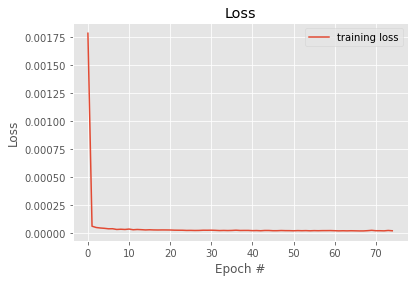

In [3]:
model = Sequential()
model.add(Dense(1000, input_shape = (trainX.shape[1],),kernel_initializer = HeUniform(), bias_initializer = HeUniform() ,activation = 'relu'))
model.add(Dense(500,kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(250, kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(125,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(60,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(1,activation = 'linear'))
opt = SGD(learning_rate = 0.015, momentum = 0.9)
model.compile(loss = 'huber_loss', optimizer = opt)
# train the model
maxEpoch = 75
H = model.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)
# plot the loss through training
plt.style.use('ggplot')
plt.figure()
plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

34/34 [==============================] - 0s 2ms/step


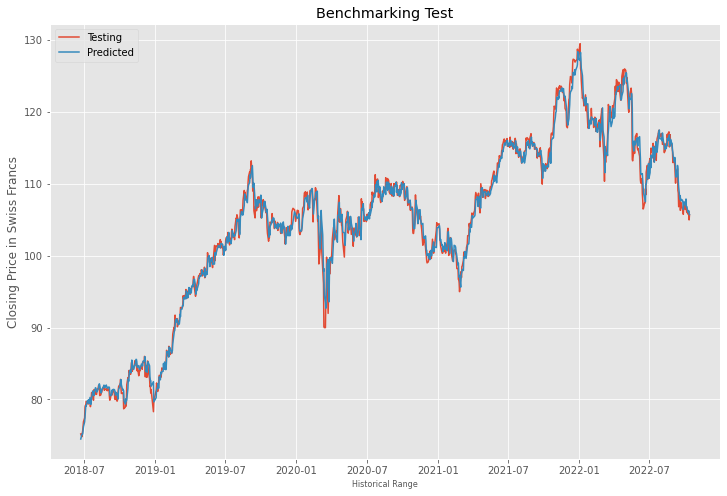

0.9270593946749942

In [4]:
predictedClose = model.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction['Predicted Close Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Price in Swiss Francs', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Close', 'Predicted Close Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Close'] - time_prediction['Predicted Close Price'])
time_prediction
time_prediction['diff'].mean()

Great! We finally got our mean error down to less than one CHF! I think we are getting to the end of our proper model. Of course, the results will not look the same for every stock or the SMI, since this mean is only applicable to Nestle's shares, but trying to achieve an error of less than one unit was a worthwhile goal for parameter tuning. It should be known after this I experimented with a few more things such as switching our activation function to tanh, different batch sizes, different learning rates around 0.015, one more attempt at regularization, another run on our new model with adam optimizer, and many different combinations of architectures (more/less neurons, more/less layers, a combination of both) and nothing gave better performance than the current model we have, so we can consider hyperparameter tuning done.

The only thing left is to find out when our model stops learning from the number of epochs. I experimented with a high range at 200, then moved down due to overfitting to 100, then to 85. In all cases, it seems that we bottom out around the 75th to 85th epoch and reach a point of diminishing (and harmful) returns when try to push past this point. The experiment for 85 epochs is below, which is close in performance to our 75 epoch run. For consistency we will stick with 75, but I think anything in the 70-90th epochs could be considered optimal.

Epoch 1/85
135/135 [==============================] - 1s 5ms/step - loss: 0.0076
Epoch 2/85
135/135 [==============================] - 1s 5ms/step - loss: 8.2498e-05
Epoch 3/85
135/135 [==============================] - 1s 5ms/step - loss: 9.0439e-05
Epoch 4/85
135/135 [==============================] - 1s 5ms/step - loss: 7.3086e-05
Epoch 5/85
135/135 [==============================] - 1s 5ms/step - loss: 6.5140e-05
Epoch 6/85
135/135 [==============================] - 1s 5ms/step - loss: 5.2616e-05
Epoch 7/85
135/135 [==============================] - 1s 5ms/step - loss: 5.9957e-05
Epoch 8/85
135/135 [==============================] - 1s 5ms/step - loss: 5.0740e-05
Epoch 9/85
135/135 [==============================] - 1s 5ms/step - loss: 4.9893e-05
Epoch 10/85
135/135 [==============================] - 1s 5ms/step - loss: 4.7248e-05
Epoch 11/85
135/135 [==============================] - 1s 5ms/step - loss: 4.9201e-05
Epoch 12/85
135/135 [==============================] - 1s 5ms/step 

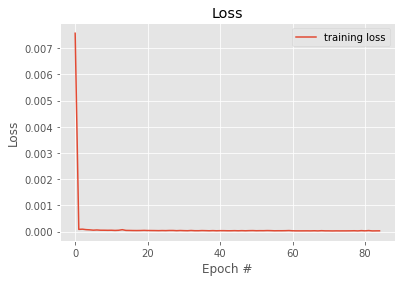

In [3]:
model = Sequential()
model.add(Dense(1000, input_shape = (trainX.shape[1],),kernel_initializer = HeUniform(), bias_initializer = HeUniform() ,activation = 'relu'))
model.add(Dense(500,kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(250, kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(125,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(60,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(1,activation = 'linear'))
opt = SGD(learning_rate = 0.015, momentum = 0.9)
model.compile(loss = 'huber_loss', optimizer = opt)
# train the model
maxEpoch = 85
H = model.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)
# plot the loss through training
plt.style.use('ggplot')
plt.figure()
plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

34/34 [==============================] - 0s 2ms/step


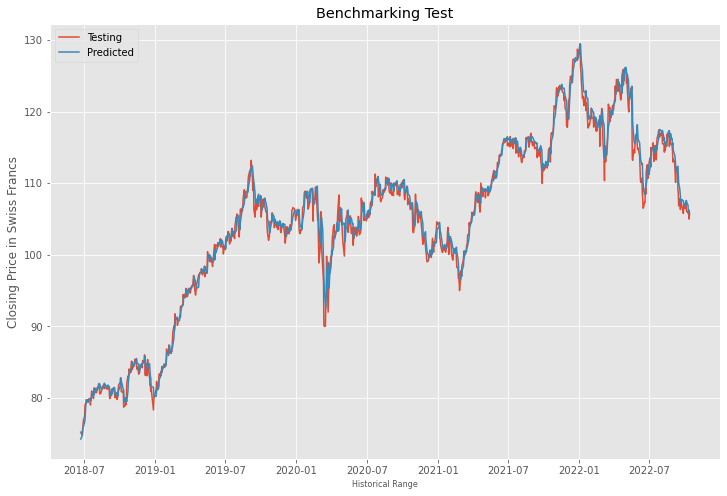

0.9562208566955174

In [4]:
predictedClose = model.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction['Predicted Close Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Price in Swiss Francs', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Close', 'Predicted Close Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Close'] - time_prediction['Predicted Close Price'])
time_prediction
time_prediction['diff'].mean()

# Final Model
Our final model consists of a feed-forward neural net with five hidden layers with 1000, 500, 250, 125, and 60 neurons respectively. Every hidden layer uses He weight initialization as well as a ReLu activation function. Our output layer is simply one neuron for regression and a linear activation function. We compute loss with Huber loss and use stochastic gradient descent as our optimizer with a learning rate of 0.015 and a momentum value of 0.9. Our batch size is 32. 

This model has been tuned rigourously with both educated tuning as well as more "random" experimenation to find the model which performs best.

# Swiss Market Index
Now that we have our final model, let's test it on the Swiss Market Index and see how it does. Keep in mind this index has greater value than the Nestle stock we are familiar with, so we should expect a different mean error but the rate of fitting look about the same. Also, remember the SMI is a weighted combination of the best 20 firms Switzerland has to offer, thus this is not a "share" which can be bought or sold, rather a metric to determine how well the Swiss' market is fairing.



In [2]:
data = yf.download("^SSMI", start="1999-03-02", end="2022-10-15")
data.to_csv('Nestle CSV')
data= data.dropna()
data = data[['Close']] #filter out other column data
closeVals = data.values #turn our data to numpy array for manipulation
train = math.floor(len(closeVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense)
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(closeVals) #scale data to help with gradient descent
scaledVals
seqdays = 30  #number of days used to construct next day price
monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTest = scaledVals[train - seqdays: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  closeVals[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%
for i in range(seqdays, len(monthTrain)):       #30 to length of rows
    trainX.append(monthTrain[i-seqdays:i, 0])   #creates sequence for 30 days training , take close column with us
    trainY.append(monthTrain[i, 0])             # creates output sequence
for i in range(30,len(monthTest)):
    testX.append(monthTest[i-seqdays:i,0])
trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists arrays for numpy
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       

[*********************100%***********************]  1 of 1 completed


Epoch 1/75
148/148 [==============================] - 1s 5ms/step - loss: 0.0087
Epoch 2/75
148/148 [==============================] - 1s 6ms/step - loss: 1.5515e-04
Epoch 3/75
148/148 [==============================] - 1s 5ms/step - loss: 1.4261e-04
Epoch 4/75
148/148 [==============================] - 1s 5ms/step - loss: 1.2291e-04
Epoch 5/75
148/148 [==============================] - 1s 5ms/step - loss: 1.1491e-04
Epoch 6/75
148/148 [==============================] - 1s 5ms/step - loss: 1.0344e-04
Epoch 7/75
148/148 [==============================] - 1s 5ms/step - loss: 1.0028e-04
Epoch 8/75
148/148 [==============================] - 1s 5ms/step - loss: 9.6803e-05
Epoch 9/75
148/148 [==============================] - 1s 5ms/step - loss: 9.0738e-05
Epoch 10/75
148/148 [==============================] - 1s 5ms/step - loss: 9.0631e-05
Epoch 11/75
148/148 [==============================] - 1s 5ms/step - loss: 9.0533e-05
Epoch 12/75
148/148 [==============================] - 1s 5ms/step 

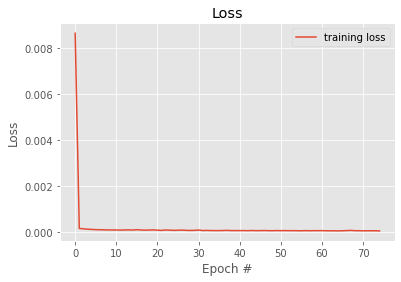

In [3]:
model = Sequential()
model.add(Dense(1000, input_shape = (trainX.shape[1],),kernel_initializer = HeUniform(), bias_initializer = HeUniform() ,activation = 'relu'))
model.add(Dense(500,kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(250, kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model.add(Dense(125,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(60,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model.add(Dense(1,activation = 'linear'))
opt = SGD(learning_rate = 0.015, momentum = 0.9)
model.compile(loss = 'huber_loss', optimizer = opt)
# train the model
maxEpoch = 75
H = model.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)
# plot the loss through training
plt.style.use('ggplot')
plt.figure()
plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

38/38 [==============================] - 0s 2ms/step


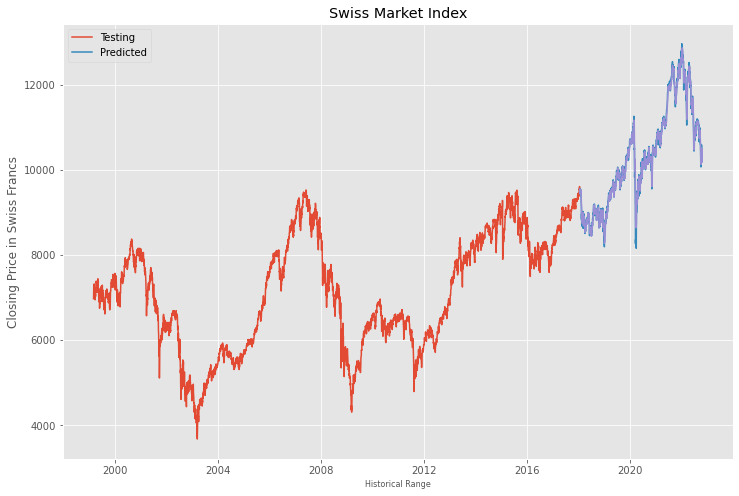

84.73304302469461

In [7]:
predictedClose = model.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction['Predicted Close Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Swiss Market Index')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Price in Swiss Francs', fontsize=12)
plt.plot(time_train['Close'])
plt.plot(time_prediction[['Close', 'Predicted Close Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Close'] - time_prediction['Predicted Close Price'])
time_prediction
time_prediction['diff'].mean()

38/38 [==============================] - 0s 2ms/step


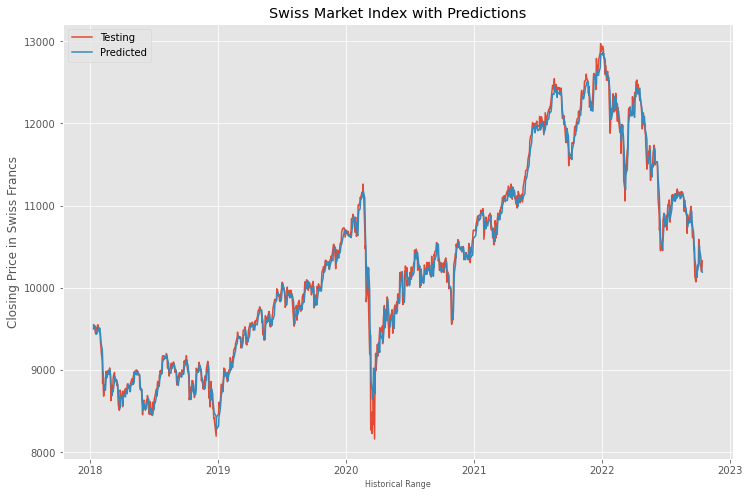

84.73304302469461

In [6]:
predictedClose = model.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction['Predicted Close Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Swiss Market Index with Predictions')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Price in Swiss Francs', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Close', 'Predicted Close Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Close'] - time_prediction['Predicted Close Price'])
time_prediction
time_prediction['diff'].mean()

An average difference of 84 CHF is nothing to balk at considering the SMI is currently (October 15th 2022) worth around 10,498 CHF. This testing run is a great testament to our model since the price range and history compared to what we tuned over (Nestle) is quite different. It seems our model will perform well on the other 19 securities we will look at.

# Conclusion 

To conclude, we have constructed a feed-forward neural network which takes historical pricing data from the last 30 trading days and uses it to predict the next day stock price. Thus, we have a model which can predict short-term security prices given a small subset of trading data. The network was optimized carefully to yield the best performance across many different sets of hyperparameters. In the end, the model was able to predict Nestle's share price within less than 1 Swiss Franc's worth of error, and 84 Swiss Franc's worth of error for the Swiss Market Index. The model is able to yield a considerably accurate time-series prediction over our testing data period, as seen by the last two plots above. 

I am happy to to see the model's plot fit so well against the true testing data. This model should not be used to make legitimate investing decisions, but it is a testament to how such simple feed-forward neural networks can produce impressive results without too much complexity. Further work could be done to improve this regression model, such as using more optimal network structures like LSTM or RNN networks.